# Emotion Detection

**Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.15.0


**Exploring Dataset**

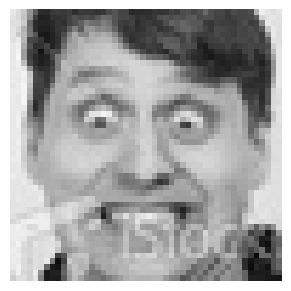

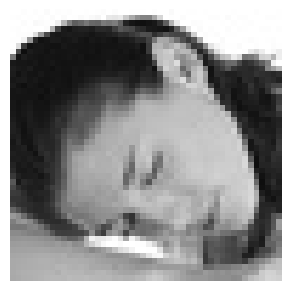

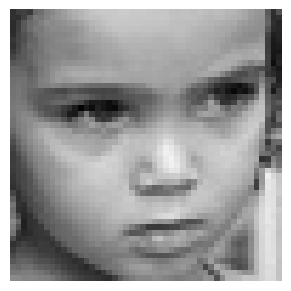

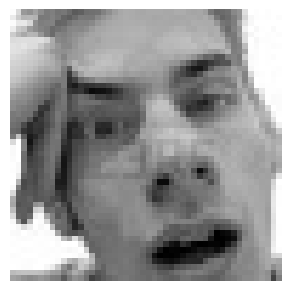

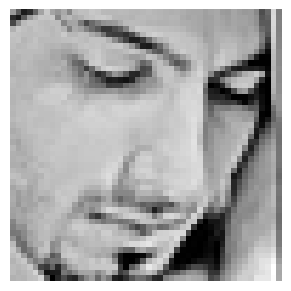

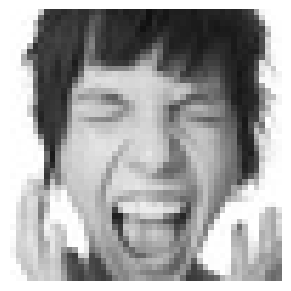

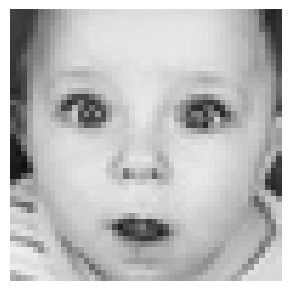

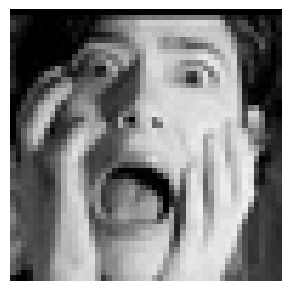

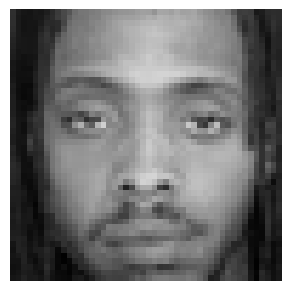

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size, 
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [4]:
def Convolution(input_tensor, filters, kernel_size): #used to find features in the image
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x) #batch normaliztion to remove overfitting and to get the training process smoothly
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x) # to decrese the dimentions of data so that the training can be done smoothly
    x = Dropout(0.25)(x) #Dropout to overcome overfitting

    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x) #to overcome overfitting
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [16]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(conv_1, 128, (5,5))
    conv_3 = Convolution(conv_2, 512, (3,3))
    conv_4 = Convolution(conv_3, 512, (3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1,512)

    output = Dense(7, activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(learning_rate = 0.0005)

    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [17]:
model = model_fer((48,48,1))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0   

**Initializing the Model**

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint, reduce_lr]

# Training the Model

**The Next cell takes time to complete**

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


448/448 [==============================] - ETA: 0s - loss: 1.8079 - accuracy: 0.3069
Epoch 1: saving model to model.weights.h5
448/448 [==============================] - 150s 328ms/step - loss: 1.8079 - accuracy: 0.3069 - val_loss: 1.5721 - val_accuracy: 0.3938 - lr: 5.0000e-04
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.4292
Epoch 2: saving model to model.weights.h5
448/448 [==============================] - 153s 341ms/step - loss: 1.4835 - accuracy: 0.4292 - val_loss: 1.3435 - val_accuracy: 0.4826 - lr: 5.0000e-04
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3344 - accuracy: 0.4885
Epoch 3: saving model to model.weights.h5
448/448 [==============================] - 153s 341ms/step - loss: 1.3344 - accuracy: 0.4885 - val_loss: 1.2761 - val_accuracy: 0.5098 - lr: 5.0000e-04
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2483 - accuracy: 0.5243
Epoch 4: saving model to model.w

**Model Evaluation**

In [10]:
model.evaluate(validation_generator)

113/113 [==============================] - 10s 86ms/step - loss: 0.9811 - accuracy: 0.6385


[0.9811396598815918, 0.638478696346283]

**Plotting Loss**

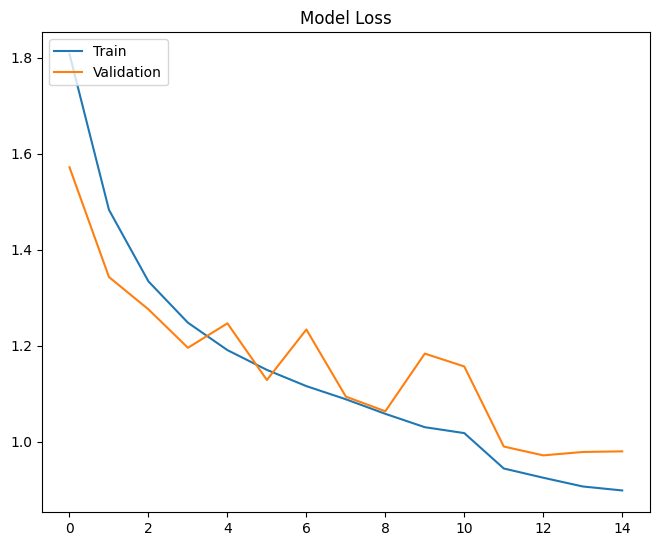

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(["Train",'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

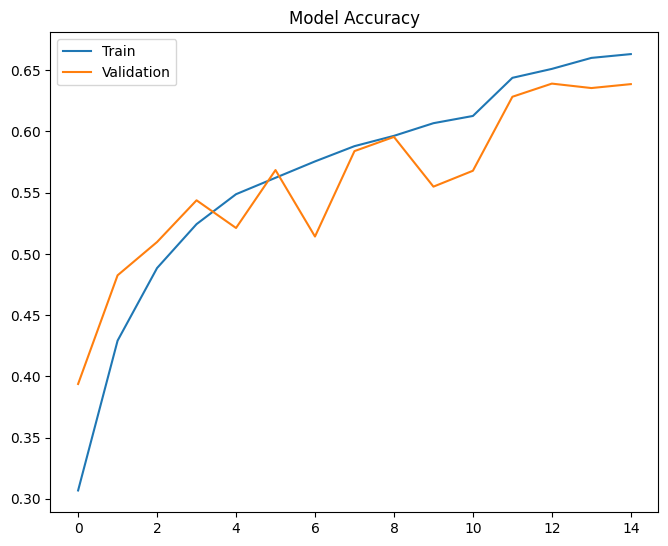

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(["Train",'Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

**Saving Model**

In [13]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)